<a href="https://colab.research.google.com/github/Prakash2023/Text-Emotion-Detection/blob/main/Final_CNN_ISEAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import string
# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

# model evaluation metrices
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/MyDrive/MINI/ISEAR/"

In [ ]:
num_classes = 7
# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 70

class_names = ['joy','fear','anger','sadness','shame','disgust','guilt']

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'shame': 4,
    'disgust': 5,
    'guilt':6
}

In [ ]:
data_train = pd.read_csv('https://raw.githubusercontent.com/SG115/Emotion-Recognition/main/ISEAR_data_training.csv', encoding='utf-8')
data_test = pd.read_csv("https://raw.githubusercontent.com/SG115/Emotion-Recognition/main/ISEAR_data_testing.csv", encoding='utf-8')

X_train = data_train.Utterance
X_test = data_test.Utterance

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
data_train

,Emotion,Utterance
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,disgust,At a gathering I found myself involuntarily si...
3,shame,When I realized that I was directing the feeli...
4,guilt,I feel guilty when when I realize that I consi...
...,...,...
6008,shame,Two years back someone invited me to be the tu...
6009,shame,I had taken the responsibility to do something...
6010,fear,I was at home and I heard a loud sound of spit...
6011,guilt,I did not do the homework that the teacher had...


In [ ]:
data_test

,Emotion,Utterance
0,joy,When I had an anticipatory honey-moon with my ...
1,sadness,It was extremely sad to me when I heard that a...
2,fear,I felt it at the same time when I felt disgust.
3,fear,After my boy-friend had beaten me for the firs...
4,fear,On the way home one Friday night in the heavy ...
...,...,...
1498,anger,In a sociology class I felt very angry towards...
1499,shame,I said something especially stupid which I did...
1500,anger,I was angry the other day because the teacher ...
1501,sadness,In my penultimate job I was responsible of a s...


In [ ]:
print(data.Emotion.value_counts())
print()
print(data_train.Emotion.value_counts())
print()
print(data_test.Emotion.value_counts())

joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: Emotion, dtype: int64

anger      885
joy        879
disgust    873
shame      857
guilt      844
sadness    842
fear       833
Name: Emotion, dtype: int64

fear       243
sadness    240
shame      214
joy        213
guilt      206
anger      194
disgust    193
Name: Emotion, dtype: int64


In [ ]:
X_train[92]

"When I did not get the salary increase that I had been expecting  \r\nand understood how little one's work was appreciated."

In [ ]:
def clean_text1(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am","im":"i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("i didn't feel humiliated")

def text_preprocessing(text):
    text = replace_contractions(text)
    text = text.lower()
    text = clean_text1(text)
    return text


In [ ]:
def clean_text(data):
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:
texts = [' '.join(text_preprocessing(text)) for text in data.Utterance]
texts_train = [' '.join(text_preprocessing(text)) for text in X_train]
texts_test = [' '.join(text_preprocessing(text)) for text in X_test]

In [ ]:
import nltk
nltk.download('punkt')
texts = [' '.join(clean_text(text)) for text in data.Utterance]
texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(texts_train[92])

When I did not get the salary increase that I had been expecting and understood how little one 's work was appreciated .


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 8992


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    1, 2307, 1793],
       [   0,    0,    0, ...,  556,  201,  190],
       [   0,    0,    0, ...,  621,    6, 4675],
       ...,
       [   0,    0,    0, ...,   10,    3,  127],
       [   0,    0,    0, ...,    7,  487,  863],
       [   0,    0,    0, ...,  225,   39, 1523]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'shame': 4,
    'disgust': 5,
    'guilt':6
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(8993, 300)

In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 8447
New words found: 545


In [ ]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

from keras.models import Sequential, Model
from keras.layers import Reshape
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Input, Flatten, Embedding, Convolution1D,Dropout,MaxPool2D,Flatten, Concatenate
from tensorflow.python.keras import regularizers
from keras.callbacks import ModelCheckpoint


In [ ]:
max_features = 100000
maxlen = 70
embed_size = 300

In [ ]:
inp = Input(shape=(maxlen, ))
x = (embedd_layer)(inp)
x = SpatialDropout1D(0.4)(x)
x = Reshape((maxlen, embed_size, 1))(x)

k1 = 3
k2 = 4
k3 = 5
conv_0 = Conv2D(64, kernel_size=(k1, embed_size), kernel_initializer='normal',activation='elu')(x)
conv_1 = Conv2D(64, kernel_size=(k2, embed_size), kernel_initializer='normal',activation='elu')(x)
conv_2 = Conv2D(64, kernel_size=(k3, embed_size), kernel_initializer='normal',activation='elu')(x)
maxpool_0 = MaxPool2D(pool_size=(maxlen - k1 + 1, 1))(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - k2 + 1, 1))(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - k3 + 1, 1))(conv_2)
z = Concatenate(axis=1)([maxpool_0, maxpool_1,maxpool_2])   
z = Flatten()(z)
z = Dropout(0.1)(z)
        
outp = Dense(7, activation="softmax")(z)
    
model = Model(inputs=inp, outputs=outp)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
print(model.summary())
#filepath="weights_best_cnn.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
#callbacks_list = [checkpoint]
hist=model.fit(X_train_pad, y_train,  epochs=25, batch_size=50,validation_data=(X_test_pad,y_test))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 300)      2697900     ['input_6[0][0]']                
                                                                                                  
 spatial_dropout1d_5 (SpatialDr  (None, 70, 300)     0           ['embedding[5][0]']              
 opout1D)                                                                                         
                                                                                                  
 reshape_5 (Reshape)            (None, 70, 300, 1)   0           ['spatial_dropout1d_5[0][0]

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 64.67%

F1 Score: 64.67


# Save a Model

In [ ]:
save_model = False
if save_model is True:
    torch.save(model_cnn,root_path+'Model Checkpoints/Model.pkl')

# Load a Model

In [ ]:
load_model = False
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Model Checkpoints/Model.pkl'))

# Confusion Matrix

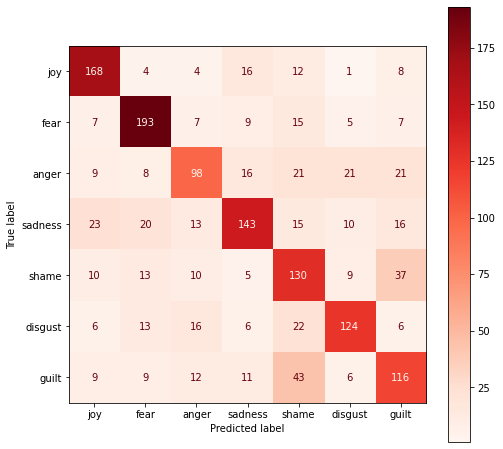

In [ ]:
cnn_cm=confusion_matrix(data_test.Emotion, predictions, labels=['joy','fear','anger','sadness','shame','disgust','guilt'])
cm_display = ConfusionMatrixDisplay(cnn_cm, display_labels=['joy','fear','anger','sadness','shame','disgust','guilt'])
# Printing the precision and recall, among other metrics
fig, ax = plt.subplots(figsize=(8,8)) # adjust the size
cm_display.plot(ax=ax,cmap='Reds',values_format='')
plt.savefig(root_path+'Model_Confusion_Matrix.jpg')

# Classification Report

In [ ]:
print(metrics.classification_report(data_test.Emotion, predictions, labels=['joy','fear','anger','sadness','shame','disgust','guilt']))

              precision    recall  f1-score   support

         joy       0.72      0.79      0.76       213
        fear       0.74      0.79      0.77       243
       anger       0.61      0.51      0.55       194
     sadness       0.69      0.60      0.64       240
       shame       0.50      0.61      0.55       214
     disgust       0.70      0.64      0.67       193
       guilt       0.55      0.56      0.56       206

    accuracy                           0.65      1503
   macro avg       0.65      0.64      0.64      1503
weighted avg       0.65      0.65      0.65      1503



In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Accuracy Plot

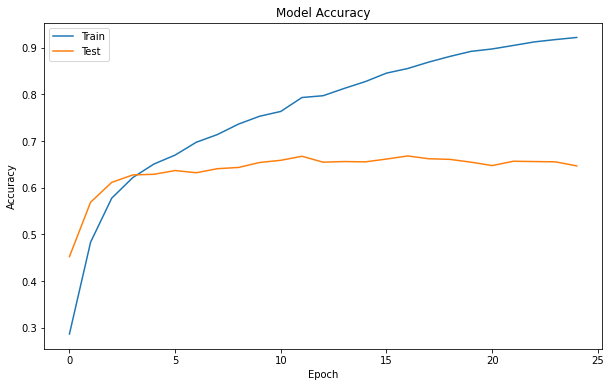

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(root_path+'Model_Accuracy.jpg')
plt.show()

# Loss Plot

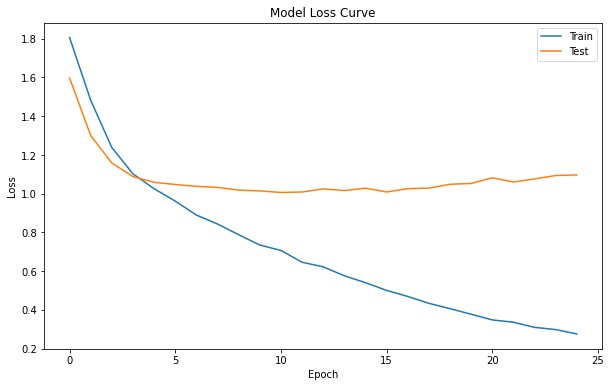

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(root_path+'Model_Loss.jpg')
plt.show()

In [ ]:
def get_prec_recall_per_emotion(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))
        
    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))
        
    return per_emotion_precision, per_emotion_recall

# Model Precision of all emotions

In [ ]:
cnn_per_prec,cnn_per_recall = get_prec_recall_per_emotion(cnn_cm)

In [ ]:
per_precision_list = pd.DataFrame({'Precision Per Emotion': cnn_per_prec}, index=class_names)
per_precision_list

,Precision Per Emotion
joy,72.414
fear,74.231
anger,61.250
sadness,69.417
shame,50.388
disgust,70.455
guilt,54.976


In [ ]:
per_recall_list = pd.DataFrame({'Recall Per Emotion': cnn_per_recall}, index=class_names)
per_recall_list

,Recall Per Emotion
joy,78.873
fear,79.424
anger,50.515
sadness,59.583
shame,60.748
disgust,64.249
guilt,56.311


# Prediction

In [ ]:
def predict_single(x):    
    # tokenize
    seq = tokenizer.texts_to_sequences(x)
    # padding
    padded = pad_sequences(seq, maxlen=max_seq_len)
    # using model
    pred = model.predict(padded)
    return pred[0]

class_names = ['joy','fear','anger','sadness','shame','disgust','guilt']

In [ ]:
text = input('Input Text: ')
ans = predict_single([text])
print()
maxx = 0
idx = 0
cnt = 0
for p in ans:
  print('Predicted Emotion: {} ({:.4f})'.format(class_names[cnt],p))
  print()
  if p>maxx:
    maxx = p
    idx = cnt
  cnt = cnt + 1

PE = ""
PE = class_names[idx] 
print("Class with Maximum Predicted Probability: ",PE)

Input Text: This message is deleted

Predicted Emotion: joy (0.1450)

Predicted Emotion: fear (0.1013)

Predicted Emotion: anger (0.2739)

Predicted Emotion: sadness (0.1811)

Predicted Emotion: shame (0.0760)

Predicted Emotion: disgust (0.0986)

Predicted Emotion: guilt (0.1239)

Class with Maximum Predicted Probability:  anger
